In [ ]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import glob
import json
import torch
import joblib
import numpy as np
import scipy.sparse.linalg as scla
from joblib import Parallel, delayed
from types import SimpleNamespace
from torch.nn import functional as F
from scipy.optimize import minimize

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from scipy.special import xlogy
from model import ParallelMLP
from sklearn.manifold import TSNE

from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import plotly.graph_objects as go

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 20

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

In [3]:
def parallel_transition(A, B, AB, theta_AB, v):
    v_par = (v * AB).sum(dim=-1, keepdim=True) * AB
    v_ort = v - v_par

    v_par_rot1 = theta_AB.cos() * v_par - theta_AB.sin() * v_par.norm(dim=-1, keepdim=True) * A
    v_par_rot2 = theta_AB.cos() * v_par + theta_AB.sin() * v_par.norm(dim=-1, keepdim=True) * A

    abs_prod1 = (v_par_rot1 * B).sum(dim=-1, keepdim=True).abs()
    abs_prod2 = (v_par_rot2 * B).sum(dim=-1, keepdim=True).abs()

    mask = (abs_prod1 < abs_prod2).tile(1, v.shape[-1])
    v_par_rot = torch.where(mask, v_par_rot1, v_par_rot2)
    v_B = v_ort + v_par_rot
    return v_B

## Overparameterized 3D example

In [86]:
torch.manual_seed(44)

N = 2
dataset = torch.tensor([
    [np.sqrt(3) / 2, 1 / 2, 0],
    [np.sqrt(3) / 2, -1 / 2, 0],
])
dataset = dataset.to(torch.float64)
dataset *= 1.0 / dataset.norm(dim=-1, keepdim=True)
inter_line = np.cross(dataset[0], dataset[1])
inter_line /= np.linalg.norm(inter_line)

lrs = torch.cat([
    torch.logspace(-3, 0, 32)[:-1],
    torch.logspace(0, np.log10(2.5), 33)[:-1],
    torch.logspace(np.log10(2.5), 1, 17),
])

lrs = lrs.to(torch.float64).unsqueeze(1)
#x = torch.randn(3, dtype=torch.float64)
x = torch.tensor([-0.8, 0.6, 0.1], dtype=torch.float64)
x /= x.norm()
x = x.unsqueeze(0).tile((len(lrs), 1))
m = x.clone()
r = torch.zeros(len(lrs), 3, dtype=torch.float64)
alpha = 0.9
gap = round(10 / (1 - alpha))
batch_size = 1

In [87]:
def batch_func(x, batch):
    losses = (x.unsqueeze(1) * batch.unsqueeze(0)).sum(-1).square().mean(-1)
    losses /= x.square().sum(dim=-1)
    return losses

In [88]:
xs = [x.clone()]
ms = [m.clone()]
rs = [r.clone()]
losses = []
T = 50000
riemann_opt = False

for t in tqdm(range(1, T + 1)):
    x_grad = x.clone()
    x_grad.requires_grad = True
    x_grad.grad = None

    indices = torch.randint(low=0, high=dataset.shape[0], size=(batch_size, ))
    l = batch_func(x_grad, dataset[indices])
    l.sum().backward()

    g = -x_grad.grad
    g = g - (g * x).sum(dim=-1, keepdim=True) * x
    g_norm = g.norm(dim=-1, keepdim=True).clip(min=1e-10)
    normed_g = g / g_norm
    angles = g_norm * lrs

    if riemann_opt:
        x = x * angles.cos() + normed_g * angles.sin()
    else:
        x = x + lrs * g

    x /= x.norm(dim=-1, keepdim=True)
    r = alpha * r + lrs * g

    prod = (x * m).sum(dim=-1, keepdim=True).clip(-1, 1)
    x_ort = x - prod * m
    x_ort /= x_ort.norm(dim=-1, keepdim=True)
    theta = (1 - alpha) * prod.arccos()
    m = theta.cos() * m + theta.sin() * x_ort
    m /= m.norm(dim=-1, keepdim=True)

    xs.append(x.clone())
    ms.append(m.clone())
    rs.append(r.clone())
    losses.append(l.detach())

    out = parallel_transition(xs[-2], xs[-1], normed_g, angles, r)
    if out.isnan().any():
        break

    r = out
    r = r - (r * x).sum(dim=-1, keepdim=True) * x

xs = torch.stack(xs, dim=0)
ms = torch.stack(ms, dim=0)
rs = torch.stack(rs, dim=0)
losses = torch.stack(losses, dim=0)

  0%|          | 0/50000 [00:00<?, ?it/s]

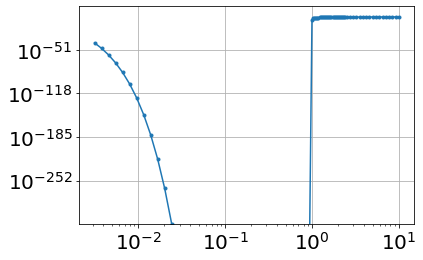

In [31]:
plt.figure(figsize=(6, 4))
plt.errorbar(lrs, losses[-100:].mean(0), losses[-100:].std(0), marker='.')
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [89]:
# Define sphere parameters
radius = 1
num_points = 200  # Sphere resolution

# Create spherical coordinates
theta = np.linspace(0, np.pi, num_points)
phi = np.linspace(0, 2 * np.pi, num_points)
theta, phi = np.meshgrid(theta, phi)

# Convert spherical to Cartesian coordinates
x_ = radius * np.sin(theta) * np.cos(phi)
y_ = radius * np.sin(theta) * np.sin(phi)
z_ = radius * np.cos(theta)
grid = torch.from_numpy(np.stack([x_, y_, z_], axis=-1))

# Calculate gradients at grid points
grid_grad = grid.clone().reshape(-1, 3)
grid_grad.requires_grad = True
grid_grad.grad = None
l = batch_func(grid_grad, dataset[0:1])
l.sum().backward()
grad1 = grid_grad.grad.clone().reshape(num_points, num_points, 3)

grid_grad.grad = None
l = batch_func(grid_grad, dataset[1:2])
l.sum().backward()
grad2 = grid_grad.grad.clone().reshape(num_points, num_points, 3)

full_grad = (grad1 + grad2) / 2
normed1 = grad1 / grad1.norm(dim=-1, keepdim=True)
normed2 = grad2 / grad2.norm(dim=-1, keepdim=True)
angle = (normed1 * normed2).sum(dim=-1).clip(-1, 1).arccos()
snr = (grad1 + grad2).norm(dim=-1) / (grad1 - grad2).norm(dim=-1)

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()

# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=(grad1.norm(dim=-1) + grad2.norm(dim=-1)) / 2,  # Single color
    colorscale='plasma_r',
    #cmin=0, cmax=0.75,
    cmin=0, cmax=1,
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=1, color='black' if i < 2 else 'orange', symbol='x'),
        line_width=3
        #name=f"object {i + 1}"
    )
    circles.append(circle)

# Combine everything in a figure
fig = go.Figure(data=[sphere] + circles)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.4 / 1.25, y=1 / 1.25, z=1.2 / 1.25)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
fig.write_image("images/op_sphere_stoch_grad.png", scale=2)

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()
# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=values,  # Single color
    cmin=0, cmax=0.75,
    colorscale='viridis_r',
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

log_indices = np.log1p(np.arange(T))
log_indices_normalized = (log_indices - log_indices.min()) / (log_indices.max() - log_indices.min())
cmap = sns.color_palette('rocket_r', as_cmap=True)
lr_id = 19
mult = 1.02
# Plot the points
points2 = go.Scatter3d(
    x=mult * xs[:, lr_id, 0], y=mult * xs[:, lr_id, 1], z=mult * xs[:, lr_id, 2],
    mode='markers+lines',
    line_width=3,
    marker=dict(size=1.5, color='mediumorchid'),#cmap(log_indices_normalized)),
    name="trajectory"
)

lr_id = 4
mult = 1.02
# Plot the points
points1 = go.Scatter3d(
    x=mult * xs[:, lr_id, 0], y=mult * xs[:, lr_id, 1], z=mult * xs[:, lr_id, 2],
    mode='markers+lines',
    marker=dict(size=1, color='crimson'),#cmap(log_indices_normalized)),
    name="trajectory"
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=1, color='black', symbol='x'),
        name=f"object {i + 1}",
        line_width=3
    )
    circles.append(circle)

# Combine everything in a figure
fig = go.Figure(data=[sphere, points1, points2] + circles)
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.4 / 1.25, y=1 / 1.25, z=1.2 / 1.25)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
#fig.write_image(f"images/op_sphere_traj_lr={lrs[lr_id].item():.2e}.png", scale=2)
#fig.write_image(f"images/op_sphere_traj.png", scale=2)

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()
# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=values,  # Single color
    cmin=0, cmax=0.75,
    colorscale='viridis_r',
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

log_indices = np.log1p(np.arange(T))
log_indices_normalized = (log_indices - log_indices.min()) / (log_indices.max() - log_indices.min())
cmap = sns.color_palette('rocket_r', as_cmap=True)
lr_id = 28
mult = 1.003
# Plot the points
points = go.Scatter3d(
    x=mult * xs[:, lr_id, 0], y=mult * xs[:, lr_id, 1], z=mult * xs[:, lr_id, 2],
    mode='markers+lines',
    marker=dict(size=1, color='crimson'),#cmap(log_indices_normalized)),
    name="trajectory"
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=1, color='black', symbol='x'),
        name=f"object {i + 1}",
        line_width=3
    )
    circles.append(circle)

# Combine everything in a figure
fig = go.Figure(data=[sphere, points] + circles)
camera = dict(
    up=dict(x=0, y=-1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.02, z=0.55)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
fig.write_image(f"images/op_sphere_stat_lr={lrs[lr_id].item():.2e}.png", scale=2)

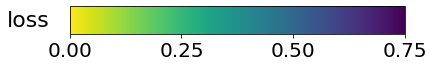

In [228]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define your colormap and value limits
cmap = cm.viridis_r
vmin, vmax = 0, 0.75

# Create a ScalarMappable and initialize a figure
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Add colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')  # or vertical
fig.text(-0.02, 0.6, 'loss', fontsize=22)
cbar.set_ticks([0, 0.25, 0.5, 0.75])
plt.savefig('images/sphere_colorbar.png', bbox_inches='tight')

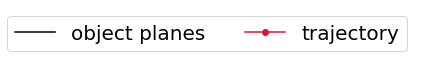

In [229]:
fig, ax = plt.subplots(figsize=(6, 1))
plt.plot([], [], color='black', label='object planes')
plt.plot([], [], color='crimson', marker='o', label='trajectory')
plt.axis('off')
plt.legend(ncol=2)
plt.savefig('images/traj_legend.png', bbox_inches='tight')

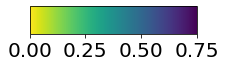

In [68]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define your colormap and value limits
cmap = cm.viridis_r
vmin, vmax = 0, 0.75

# Create a ScalarMappable and initialize a figure
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create a figure
fig, ax = plt.subplots(figsize=(3, 1))
fig.subplots_adjust(bottom=0.5)

# Add colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')  # or vertical
cbar.set_ticks([0, 0.25, 0.5, 0.75])
plt.savefig('images/sphere_colorbar_loss.png', bbox_inches='tight')

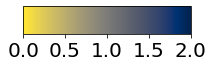

In [69]:
# Define your colormap and value limits
cmap = cm.cividis_r
vmin, vmax = 0, 2

# Create a ScalarMappable and initialize a figure
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create a figure
fig, ax = plt.subplots(figsize=(3, 1))
fig.subplots_adjust(bottom=0.5)

# Add colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')  # or vertical
cbar.set_ticks([0, 0.5, 1, 1.5, 2.0])
plt.savefig('images/sphere_colorbar_snr.png', bbox_inches='tight')

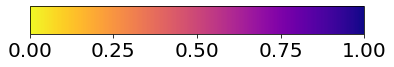

In [70]:
# Define your colormap and value limits
cmap = cm.plasma_r
vmin, vmax = 0, 1

# Create a ScalarMappable and initialize a figure
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Add colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')  # or vertical
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.savefig('images/sphere_colorbar_grad.png', bbox_inches='tight')

In [9]:
full_grad_norms = []
stoch_grad_norms = []
stoch_grad_angles = []
grad_noise_norms = []
snrs = []
full_losses = []
batch_losses = []
iters = np.arange(1, 100).tolist() + np.logspace(2, np.log10(T), 401).astype(int).tolist()
iters = np.array(iters)

for it in tqdm(iters):
    x = xs[it]
    x_grad = x.clone()
    x_grad.requires_grad = True

    x_grad.grad = None
    l = batch_func(x_grad, dataset)
    l.sum().backward()
    full_grad = -x_grad.grad
    full_losses.append(l.detach())

    stoch_grads = []
    cur_losses = []
    for i in range(2):
        x_grad.grad = None
        l = batch_func(x_grad, dataset[i:i + 1])
        l.sum().backward()
        stoch_grad = -x_grad.grad
        stoch_grads.append(stoch_grad)
        cur_losses.append(l.detach())

    stoch_grads = torch.stack(stoch_grads, dim=1)
    cur_losses = torch.stack(cur_losses, dim=1)

    full_grad_norms.append(full_grad.norm(dim=-1))
    stoch_grad_norms.append(stoch_grads.norm(dim=-1))
    grad_noise_norms.append(0.5 * (stoch_grads[:, 0] - stoch_grads[:, 1]).norm(dim=-1))

    batch_losses.append(cur_losses)

    normed1 = stoch_grads[:, 0] / stoch_grads[:, 0].norm(dim=-1, keepdim=True)
    normed2 = stoch_grads[:, 1] / stoch_grads[:, 1].norm(dim=-1, keepdim=True)
    stoch_grad_angles.append(
        (normed1 * normed2).sum(dim=-1).clip(-1, 1).arccos()
    )
    
    snrs.append(
        (stoch_grads[:, 0] + stoch_grads[:, 1]).norm(dim=-1) / 
        (stoch_grads[:, 0] - stoch_grads[:, 1]).norm(dim=-1)
    )

full_grad_norms = torch.stack(full_grad_norms, dim=1)
stoch_grad_norms = torch.stack(stoch_grad_norms, dim=1)
stoch_grad_angles = torch.stack(stoch_grad_angles, dim=1)
grad_noise_norms = torch.stack(grad_noise_norms, dim=1)
batch_losses = torch.stack(batch_losses, dim=1)
full_losses = torch.stack(full_losses, dim=1)
snrs = torch.stack(snrs, dim=1)

  0%|          | 0/500 [00:00<?, ?it/s]

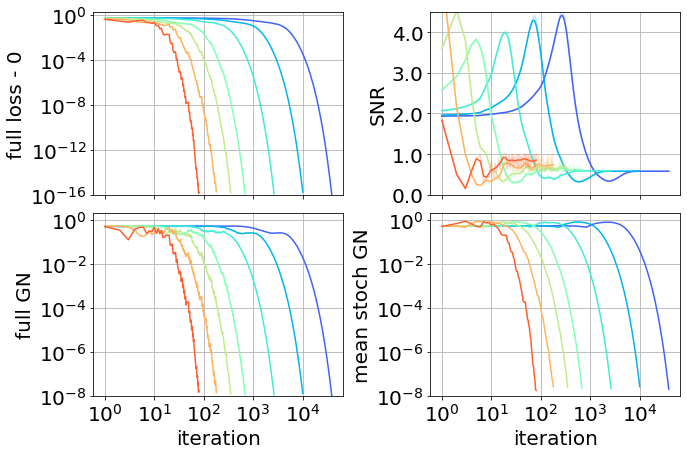

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12 / 1.25, 8 / 1.25), sharex=True)
plt.tight_layout()

lr_ids = [0, 6, 12, 18, 21, 24, 27]
colors = sns.color_palette('rainbow', len(lr_ids))
thr = 1e-16
filter_sigma = 0.1

for i, lr_id in enumerate(lr_ids):
    mask = full_losses[lr_id] >= thr
    axs[0, 0].plot(iters[mask], full_losses[lr_id, mask], color=colors[i], alpha=1)
    axs[1, 0].plot(iters[mask], full_grad_norms[lr_id, mask], color=colors[i],
                   label=f'{lrs[lr_id].item():.1e}', alpha=1)
    axs[1, 1].plot(iters[mask], stoch_grad_norms[lr_id, mask].mean(-1), color=colors[i],
                   label=f'{lrs[lr_id].item():.1e}', alpha=1)
    
    log_iters = torch.tensor(iters).to(torch.float64).log()[mask]
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    axs[0, 1].plot(iters[mask], snrs[lr_id, mask], color=colors[i], alpha=0.25)
    axs[0, 1].plot(iters[mask], F @ snrs[lr_id, mask], color=colors[i], label=f'{lrs[lr_id].item():.1e}')

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.grid()

for ax in axs[-1]:
    ax.set_xlabel('iteration')

for ax in [axs[0, 0], axs[1, 0], axs[1, 1]]:
    ax.set_yscale('log')
for ax in [axs[1, 0], axs[1, 1]]:
    ax.set_ylim(1e-8, 2)
    ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1])

axs[0, 0].set_ylim(1e-16, 2)
axs[0, 0].set_yticks([1e-16, 1e-12, 1e-8, 1e-4, 1])
axs[0, 1].set_ylim(0.0, 4.5)
axs[0, 1].set_yticks(range(0, 5), [f'{v:.1f}' for v in range(0, 5)])
axs[0, 0].set_ylabel('full loss - 0')
axs[0, 1].set_ylabel('SNR')
axs[1, 0].set_ylabel('full GN')
axs[1, 1].set_ylabel('mean stoch GN')

plt.subplots_adjust(hspace=0.1, wspace=0.35)
plt.savefig('images/op_sphere_metrics.png', bbox_inches='tight')

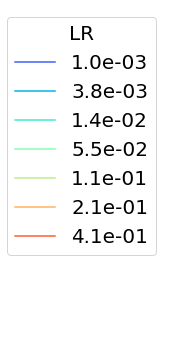

In [13]:
lr_ids = [0, 6, 12, 18, 21, 24, 27]
fig = plt.figure(figsize=(2, 6))
colors = sns.color_palette('rainbow', len(lr_ids))

for i, lr_id in enumerate(lr_ids):
    plt.plot([], [], color=colors[i], label=f'{lrs[lr_id].item():.1e}')

plt.axis('off')
plt.legend(ncol=1, title='LR')
plt.savefig('images/sphere_snr_legend.png', bbox_inches='tight')

## Underparameterized 3D example

In [78]:
torch.manual_seed(43)

N = 3
dataset = torch.tensor([
    [1, 0, 0.2],
    [-1/2, np.sqrt(3) / 2, 0.2],
    [-1/2, -np.sqrt(3) / 2, 0.2],
])
dataset = dataset.to(torch.float64)
dataset *= 1.0 / dataset.norm(dim=-1, keepdim=True)
inter_line = np.cross(dataset[0], dataset[1])
inter_line /= np.linalg.norm(inter_line)

lrs = torch.cat([
    torch.logspace(-3, 0, 32)[:-1],
    torch.logspace(0, np.log10(2.5), 33)[:-1],
    torch.logspace(np.log10(2.5), 1, 17),
])

lrs = lrs.to(torch.float64).unsqueeze(1)
#x = torch.randn(3, dtype=torch.float64)
x = torch.tensor([-0.8, 0.6, 0.1], dtype=torch.float64)
x /= x.norm()
x = x.unsqueeze(0).tile((len(lrs), 1))
m = x.clone()
r = torch.zeros(len(lrs), 3, dtype=torch.float64)
alpha = 0.9
gap = round(10 / (1 - alpha))
batch_size = 1

In [79]:
# Define sphere parameters
radius = 1
num_points = 200  # Sphere resolution

# Create spherical coordinates
theta = np.linspace(0, np.pi, num_points)
phi = np.linspace(0, 2 * np.pi, num_points)
theta, phi = np.meshgrid(theta, phi)

# Convert spherical to Cartesian coordinates
x_ = radius * np.sin(theta) * np.cos(phi)
y_ = radius * np.sin(theta) * np.sin(phi)
z_ = radius * np.cos(theta)
grid = torch.from_numpy(np.stack([x_, y_, z_], axis=-1))

# Calculate gradients at grid points
grid_grad = grid.clone().reshape(-1, 3)
grid_grad.requires_grad = True
grid_grad.grad = None
l = batch_func(grid_grad, dataset[0:1])
l.sum().backward()
grad1 = grid_grad.grad.clone().reshape(num_points, num_points, 3)

grid_grad.grad = None
l = batch_func(grid_grad, dataset[1:2])
l.sum().backward()
grad2 = grid_grad.grad.clone().reshape(num_points, num_points, 3)

grid_grad.grad = None
l = batch_func(grid_grad, dataset[2:3])
l.sum().backward()
grad3 = grid_grad.grad.clone().reshape(num_points, num_points, 3)

stoch_grads = torch.stack([grad1, grad2, grad3], axis=0)
full_grad = stoch_grads.mean(0)

snr = full_grad.norm(dim=-1) / ((stoch_grads - full_grad.unsqueeze(0)).square().sum(dim=-1)).mean(0).sqrt()

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()

# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=stoch_grads.norm(dim=-1).mean(0),  # Single color
    colorscale='plasma_r',
    cmin=0, cmax=1,
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1], dataset[2]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=3, color='black', symbol='x'),
        #name=f"object {i + 1}",
        line_width=3
    )
    circles.append(circle)

# Combine everything in a figure
fig = go.Figure(data=[sphere] + circles)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.9 / 1.25, y=0.4 / 1.25, z=1.5 / 1.25)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
fig.write_image("images/up_sphere_stoch_grad.png", scale=2)

In [80]:
xs = [x.clone()]
ms = [m.clone()]
rs = [r.clone()]
losses = []
T = 50000
riemann_opt = False

for t in tqdm(range(1, T + 1)):
    x_grad = x.clone()
    x_grad.requires_grad = True
    x_grad.grad = None

    indices = torch.randint(low=0, high=dataset.shape[0], size=(batch_size, ))
    l = batch_func(x_grad, dataset[indices])
    l.sum().backward()

    g = -x_grad.grad
    g = g - (g * x).sum(dim=-1, keepdim=True) * x
    g_norm = g.norm(dim=-1, keepdim=True).clip(min=1e-10)
    normed_g = g / g_norm
    angles = g_norm * lrs

    if riemann_opt:
        x = x * angles.cos() + normed_g * angles.sin()
    else:
        x = x + lrs * g

    x /= x.norm(dim=-1, keepdim=True)
    r = alpha * r + lrs * g

    prod = (x * m).sum(dim=-1, keepdim=True).clip(-1, 1)
    x_ort = x - prod * m
    x_ort /= x_ort.norm(dim=-1, keepdim=True)
    theta = (1 - alpha) * prod.arccos()
    m = theta.cos() * m + theta.sin() * x_ort
    m /= m.norm(dim=-1, keepdim=True)

    xs.append(x.clone())
    ms.append(m.clone())
    rs.append(r.clone())
    losses.append(l.detach())

    out = parallel_transition(xs[-2], xs[-1], normed_g, angles, r)
    if out.isnan().any():
        break

    r = out
    r = r - (r * x).sum(dim=-1, keepdim=True) * x

xs = torch.stack(xs, dim=0)
ms = torch.stack(ms, dim=0)
rs = torch.stack(rs, dim=0)
losses = torch.stack(losses, dim=0)

  0%|          | 0/50000 [00:00<?, ?it/s]

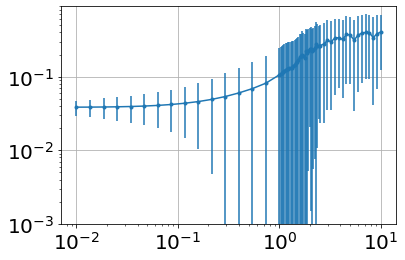

In [147]:
plt.figure(figsize=(6, 4))
plt.errorbar(lrs, losses[-100:].mean(0), losses[-100:].std(0), marker='.')
plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-3, 0.9))
#plt.xlim(0.9, 11)
plt.grid()

In [ ]:
plt.figure(figsize=(6, 4))
plt.errorbar(lrs, all_knn_ents[:, -10:, 9].mean(1), marker='.')
plt.axvline(lrs[42])
plt.xscale('log')
#plt.ylim(12, 20)
#plt.xlim(0.9, 11)
plt.grid()

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()
# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=values,  # Single color
    cmin=0, cmax=0.75,
    colorscale='viridis_r',
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

log_indices = np.log1p(np.arange(T))
log_indices_normalized = (log_indices - log_indices.min()) / (log_indices.max() - log_indices.min())
cmap = sns.color_palette('rocket_r', as_cmap=True)
lr_id = 4
mult = 1.015
bd = 0
# Plot the points
points1 = go.Scatter3d(
    x=mult * xs[:bd, lr_id, 0], y=mult * xs[:bd, lr_id, 1], z=mult * xs[:bd, lr_id, 2],
    mode='markers+lines',
    marker=dict(size=1, color='crimson'),#cmap(log_indices_normalized)),
    name="trajectory"
)
points2 = go.Scatter3d(
    x=mult * xs[bd:, lr_id, 0], y=mult * xs[bd:, lr_id, 1], z=mult * xs[bd:, lr_id, 2],
    mode='markers',
    marker=dict(size=1, color='crimson'),#cmap(log_indices_normalized)),
    name="trajectory", opacity=1.0
)

lr_id = 19
mult = 1.01
bd = 90
# Plot the points
points3 = go.Scatter3d(
    x=mult * xs[:bd, lr_id, 0], y=mult * xs[:bd, lr_id, 1], z=mult * xs[:bd, lr_id, 2],
    mode='markers+lines',
    marker=dict(size=1.5, color='mediumorchid'),#cmap(log_indices_normalized)),
    name="trajectory",
    line_width=3,
)
points4 = go.Scatter3d(
    x=mult * xs[bd:, lr_id, 0], y=mult * xs[bd:, lr_id, 1], z=mult * xs[bd:, lr_id, 2],
    mode='markers',
    marker=dict(size=1, color='mediumorchid'),#cmap(log_indices_normalized)),
    name="trajectory", opacity=1.0
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1], dataset[2]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=3, color='black', symbol='x'),
        name=f"object {i + 1}",
        line_width=3
    )
    circles.append(circle)


# Combine everything in a figure
fig = go.Figure(data=[sphere, points1, points2, points3, points4] + circles)
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.9 / 1.25, y=0.4 / 1.25, z=1.5 / 1.25)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
#fig.write_image(f"images/up_sphere_traj_lr={lrs[lr_id].item():.2e}.png", scale=2)
fig.write_image(f"images/up_sphere_traj.png", scale=2)

In [ ]:
values = (dataset.unsqueeze(0).unsqueeze(1) * grid.unsqueeze(2)).sum(-1).square().mean(-1).numpy()
# Create a transparent sphere
sphere = go.Surface(
    x=x_, y=y_, z=z_,
    surfacecolor=values,  # Single color
    cmin=0, cmax=0.75,
    colorscale='viridis_r',
    #colorscale=[[0, 'white'], [1, 'black']],  # Solid blue
    showscale=False, opacity=1
)

log_indices = np.log1p(np.arange(T))
log_indices_normalized = (log_indices - log_indices.min()) / (log_indices.max() - log_indices.min())
cmap = sns.color_palette('rocket_r', as_cmap=True)
lr_id = 24
mult = 1.01
bd = 0
# Plot the points
points2 = go.Scatter3d(
    x=mult * xs[:, lr_id, 0], y=mult * xs[:, lr_id, 1], z=mult * xs[:, lr_id, 2],
    mode='markers',
    marker=dict(size=1, color='red'),#cmap(log_indices_normalized)),
    name="trajectory", opacity=0.03
)

circles = []
for i, normal in enumerate([dataset[0], dataset[1], dataset[2]]):
    normal = normal.clone()
    normal /= normal.norm()
    normal = normal.numpy()
    u1, u2 = np.array([0., 1., 0.]), np.array([0., 0., 1.])
    u1 -= (u1 @ normal) * normal
    u1 /= np.linalg.norm(u1)
    u2 -= (u2 @ normal) * normal + (u2 @ u1) * u1
    u2 /= np.linalg.norm(u2)
    phi = np.linspace(0, 2 * np.pi, 100)
    xc = 1.005 * (u1[0] * np.cos(phi) + u2[0] * np.sin(phi))
    yc = 1.005 * (u1[1] * np.cos(phi) + u2[1] * np.sin(phi))
    zc = 1.005 * (u1[2] * np.cos(phi) + u2[2] * np.sin(phi))
    
    circle = go.Scatter3d(
        x=xc, y=yc, z=zc,
        mode='lines',
        marker=dict(size=3, color='black', symbol='x'),
        name=f"object {i + 1}",
        line_width=3
    )
    circles.append(circle)


# Combine everything in a figure
fig = go.Figure(data=[sphere, points1, points2] + circles)
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0, z=1.25)
)
fig.update_layout(
    scene_camera=camera, showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    )
)

# Show the figure
fig.show()
fig.write_image(f"images/up_sphere_stat_lr={lrs[lr_id].item():.2e}.png", scale=2)

In [61]:
full_grad_norms = []
stoch_grad_norms = []
grad_noise_norms = []
snrs = []
full_losses = []
batch_losses = []
iters = np.arange(1, 100).tolist() + np.logspace(2, np.log10(T), 401).astype(int).tolist()
iters = np.array(iters)

for it in tqdm(iters):
    x = xs[it]
    x_grad = x.clone()
    x_grad.requires_grad = True

    x_grad.grad = None
    l = batch_func(x_grad, dataset)
    l.sum().backward()
    full_grad = -x_grad.grad
    full_losses.append(l.detach())

    stoch_grads = []
    cur_losses = []
    for i in range(3):
        x_grad.grad = None
        l = batch_func(x_grad, dataset[i:i + 1])
        l.sum().backward()
        stoch_grad = -x_grad.grad
        stoch_grads.append(stoch_grad)
        cur_losses.append(l.detach())

    stoch_grads = torch.stack(stoch_grads, dim=1)
    cur_losses = torch.stack(cur_losses, dim=1)
    full_grad_norm = full_grad.norm(dim=-1)
    grad_noise_norm = (stoch_grads - full_grad.unsqueeze(1)).norm(dim=-1)

    full_grad_norms.append(full_grad.norm(dim=-1))
    stoch_grad_norms.append(stoch_grads.norm(dim=-1))
    grad_noise_norms.append(grad_noise_norm)
    batch_losses.append(cur_losses)
    
    snrs.append(full_grad_norm / grad_noise_norm.square().mean(1).sqrt())

full_grad_norms = torch.stack(full_grad_norms, dim=1)
stoch_grad_norms = torch.stack(stoch_grad_norms, dim=1)
grad_noise_norms = torch.stack(grad_noise_norms, dim=1)
batch_losses = torch.stack(batch_losses, dim=1)
full_losses = torch.stack(full_losses, dim=1)
snrs = torch.stack(snrs, dim=1)

  0%|          | 0/500 [00:00<?, ?it/s]

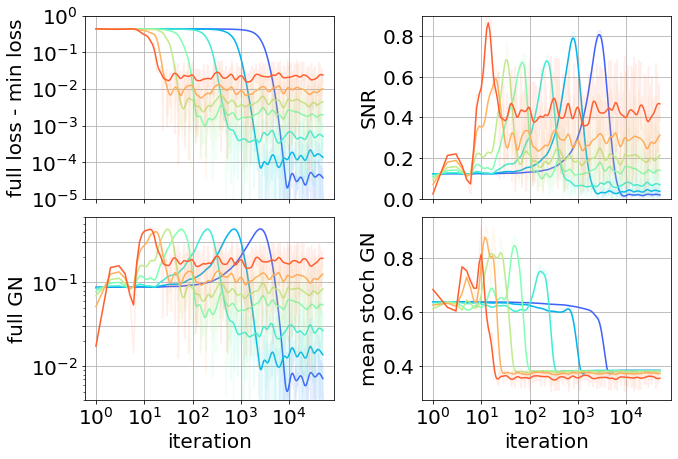

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(12 / 1.25, 8 / 1.25), sharex=True)
plt.tight_layout()

lr_ids = [0, 6, 12, 18, 21, 24, 27]
colors = sns.color_palette('rainbow', len(lr_ids))
thr = 1e-16
filter_sigma = 0.1
loss_min = batch_func(torch.tensor([[0, 0, 1]]), dataset).item()

log_iters = torch.tensor(iters).to(torch.float64).log()
F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
F = (F / 2 / filter_sigma ** 2).exp()
F /= F.sum(dim=1, keepdim=True)

for i, lr_id in enumerate(lr_ids):
    axs[0, 0].plot(iters, full_losses[lr_id, :] - loss_min, color=colors[i], alpha=0.1)
    axs[0, 0].plot(iters, F @ full_losses[lr_id, :] - loss_min,
                   color=colors[i], label=f'{lrs[lr_id].item():.1e}')

    axs[1, 0].plot(iters, full_grad_norms[lr_id, :], color=colors[i], alpha=0.1)
    axs[1, 0].plot(iters, F @ full_grad_norms[lr_id, :],
                   color=colors[i], label=f'{lrs[lr_id].item():.1e}')

    axs[1, 1].plot(iters, stoch_grad_norms[lr_id, :].mean(-1), color=colors[i], alpha=0.1)
    axs[1, 1].plot(iters, F @ stoch_grad_norms[lr_id, :].mean(-1),
                   color=colors[i], label=f'{lrs[lr_id].item():.1e}')
    
    axs[0, 1].plot(iters, snrs[lr_id, :], color=colors[i], alpha=0.1)
    axs[0, 1].plot(iters, F @ snrs[lr_id, :], color=colors[i], label=f'{lrs[lr_id].item():.1e}')

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.grid()

for ax in axs[-1]:
    ax.set_xlabel('iteration')

for ax in [axs[0, 0], axs[1, 0]]:
    ax.set_yscale('log')

axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim(1e-5, 1)
axs[0, 0].set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
axs[0, 1].set_ylim(0.0, 0.9)
axs[0, 1].set_yticks(np.arange(0, 0.81, 0.2))
axs[1, 0].set_ylim(4e-3, 0.6)
axs[1, 0].set_yticks([1e-2, 3e-2, 1e-1, 3e-1])

axs[0, 0].set_ylabel('full loss - min loss')
axs[0, 1].set_ylabel('SNR')
axs[1, 0].set_ylabel('full GN')
axs[1, 1].set_ylabel('mean stoch GN')

plt.subplots_adjust(hspace=0.1, wspace=0.35)
plt.savefig('images/up_sphere_metrics.png', bbox_inches='tight')